In [2]:
# imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

In [7]:
def load_data(file_path):
    """
    Load data from a CSV file.
    
    Parameters:
    - file_path: str, path to the CSV file.
    
    Returns:
    - pandas DataFrame, the loaded data.
    """
    return pd.read_csv(file_path)
    
def check_is_numeric(data):
    """
    Checks if the columns (excluding 'time') are numeric.

    Parameters:
    - data : pandas dataframe
    
    Returns:
    Boolean variable(True/ False) and prints the non-numeric columns.
    """
    flag = 0
    non_numeric_cols = []
    for column in data.columns:
        if column.lower() == 'time':  # Skip the 'time' column
            continue
        if not is_numeric_dtype(data[column]):
            flag += 1
            non_numeric_cols.append(column)
    if flag != 0:
        print(f'Please Provide Numeric Data.\nNon-numeric Attributes are- {non_numeric_cols}')
        return False
    return True

        
def granger_causality_test(data, max_lag):
    """
    Perform Granger causality test.
    
    Parameters:
    - data: pandas DataFrame, the data containing the time series.
    - max_lag: int, the maximum lag to be tested.
    
    Returns:
    - test_result: dict, the results of the Granger causality test.
    """
    return grangercausalitytests(data, max_lag, verbose=True)

def plot_time_series(data, lag):
    """
    Plot the two time series with a specified lag.
    
    Parameters:
    - data: pandas DataFrame, the data containing the time series.
    - lag: int, the lag to apply.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data['time'], data['x'], label='Stand 3-4 Tension Reference')
    plt.plot(data['time'], data['y'].shift(lag), label=f'Operator_Q_VW_OLD_OPTECH (shifted by {lag} lags)')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'Time Series with Lag {lag}')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

### Driver code for user to run

Enter the maximum lag value to test:  20



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4376  , p=0.2306  , df_denom=7986, df_num=1
ssr based chi2 test:   chi2=1.4382  , p=0.2304  , df=1
likelihood ratio test: chi2=1.4381  , p=0.2305  , df=1
parameter F test:         F=1.4376  , p=0.2306  , df_denom=7986, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5150  , p=0.5975  , df_denom=7983, df_num=2
ssr based chi2 test:   chi2=1.0306  , p=0.5973  , df=2
likelihood ratio test: chi2=1.0306  , p=0.5973  , df=2
parameter F test:         F=0.5150  , p=0.5975  , df_denom=7983, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0575  , p=0.9819  , df_denom=7980, df_num=3
ssr based chi2 test:   chi2=0.1727  , p=0.9819  , df=3
likelihood ratio test: chi2=0.1727  , p=0.9819  , df=3
parameter F test:         F=0.0575  , p=0.9819  , df_denom=7980, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0735  , p=0.

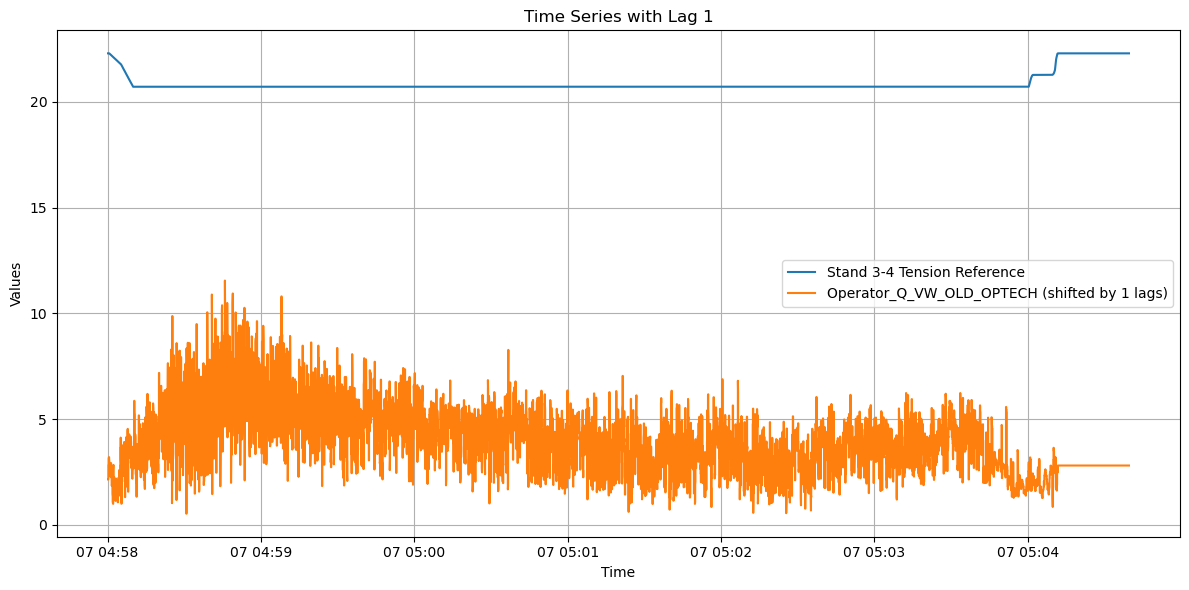

In [8]:
def main():
    try:
        # Prompt user for file paths and lag value
        # file_path_1 = input("Enter the path for the first time series CSV file: ")
        # file_path_2 = input("Enter the path for the second time series CSV file: ")
        file_path_1 = r"D:\Stelco\Work\Dynamic Correlation\Key\Master whole Phase\5508568.csv"
        file_path_2 = r"D:\Stelco\Work\Dynamic Correlation\Key\Master whole Phase\5508568.csv"
        max_lag = int(input("Enter the maximum lag value to test: "))
        
        # Load data
        # data1 = load_data(file_path_1)
        # data2 = load_data(file_path_2)
        data1 = pd.read_csv(file_path_1,usecols=['Time','Stand 3-4 Tension Reference'])
        data2 = pd.read_csv(file_path_2,usecols=['Time','Operator_Q_VW_OLD_OPTECH'])

        data1['Time'] = pd.to_datetime(data1['Time'], errors='coerce')
        data2['Time'] = pd.to_datetime(data2['Time'], errors='coerce')

        
        if(len(data1.columns)!=2 or len(data2.columns)!=2):
            print('Test requires exactly 2 columns - time and values for both datasets!')
            return
        
        # Assuming the time series are in columns named 'value' in both files
        # Rename columns to unify
        data1.rename(columns={data1.columns[0]: 'time', data1.columns[1]: 'x'}, inplace=True)
        data2.rename(columns={data2.columns[0]: 'time', data2.columns[1]: 'y'}, inplace=True)
    
        # Check if both have the same time intervals and same duration
        if (data1.time.equals(data2.time))==False:
            print('Values in the Time columns are different in both datasets.\nTest can not be performed')
            return
    
        # Merge the two dataframes on 'time'
        merged_data = pd.merge(data1, data2, on='time')
    
        # Checking for numeric data
        if(check_is_numeric(merged_data)==False):
            return
            
        # Handling missing values (if any)
        # imputer = KNNImputer(n_neighbors=8)
        # merged_data = pd.DataFrame(imputer.fit_transform(merged_data), columns=merged_data.columns)

        # Save time column
        time_col = merged_data['time']
        
        # Drop time column before imputation
        numeric_data = merged_data.drop(columns=['time'])
        
        # Impute only numeric columns
        imputer = KNNImputer(n_neighbors=8)
        imputed_array = imputer.fit_transform(numeric_data)
        imputed_data = pd.DataFrame(imputed_array, columns=numeric_data.columns)
        
        # Add time column back
        merged_data = pd.concat([time_col.reset_index(drop=True), imputed_data], axis=1)

        
        # Perform Granger causality test
        test_result = granger_causality_test(merged_data[['x', 'y']], max_lag)
    
        # Extract and print p-values, and find the lag with the smallest p-value
        best_lag = None
        best_p_value = float('inf')
        print("\nGranger Causality Test Results:")
        for key in test_result:
            f_test_p_value = test_result[key][0]['ssr_ftest'][1]
            print(f'Lag {key}: p-value = {f_test_p_value}')
            if f_test_p_value < best_p_value:
                best_p_value = f_test_p_value
                best_lag = key

        # Plot the series with the best lag
        if best_lag is not None:
            print(f"\nBest lag based on p-value: {best_lag}")
            plot_time_series(merged_data, best_lag)
        else:
            print("No significant Granger causality found.")
            
    except Exception as e:
        print(e)
if __name__ == "__main__":
    main()


# Usage Example:
# Enter the path for the first time series CSV file: time_series_x.csv
# Enter the path for the second time series CSV file: time_series_y.csv
# Enter the maximum lag value to test: 20